# Simulator 1
Now we try to ensure that our simulation follows Poisson's Equastion

In [17]:
from fluid_sim import Fluid
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Initialize Fluid without pipes and overrelaxation
fluid = Fluid(1, 64,64,1, 1.0)
fluid.initialize()

In [19]:
# Add Obstacle and simulate one step
fluid.set_obstacle(fluid.num_x // 2, fluid.num_y // 2, 1 / 30)
fluid.simulate(1/30, -9.81, 40)

In [20]:
# Apply gravity and solve incomressibility to obtain pressure
fluid.integrate(1/30, -9.81)
fluid.p = np.zeros((fluid.num_x, fluid.num_y))
fluid.solve_incomressibility(40, 1/30)

In [21]:
# save velocities and also center them in cells
v = fluid.v.copy()
u = fluid.u.copy()

new_u = u.copy()
new_v = v.copy()

for i in range(63):
    for j in range(63):
        new_u[i,j] = (u[i,j] + u[i+1, j]) / 2
        new_v[i,j] = (v[i,j] + v[i, j+1]) / 2

Now we have prepared our data and let's calculate The Laplaccian of P and RHS of Poisson's equation

In [24]:
# /delta^2 p = d^2p / dx^2 + d^2p / dy^2
laplassian_p = np.zeros((64,64))
dx = dy = fluid.h
for i in range(1,63):
    for j in range(1, 63):
        laplassian_p[i,j] = (fluid.p[i+1][j]  - 2*fluid.p[i][j] + fluid.p[i-1][j]) / dx**2 + (fluid.p[i, j+1]  - 2*fluid.p[i][j] + fluid.p[i, j-1] ) / dy ** 2
        # for now we don't care about borders

In [25]:
dt = 1/30 
g = np.zeros((64,64))  # RHS of Poisson's equation
for i in range(1,63):
    for j in range(1, 63):
        # g[i,j] = - (du_dx[i,j]**2 + dv_dy[i,j]**2 + 2*du_dy[i,j]*dv_dx[i,j])
        g[i, j] = fluid.density / dt * ((new_u[i+1][j]  -  new_u[i-1][j]) / (2*dx) + (new_v[i,j+1] - new_v[i, j-1]) / (2*dy))

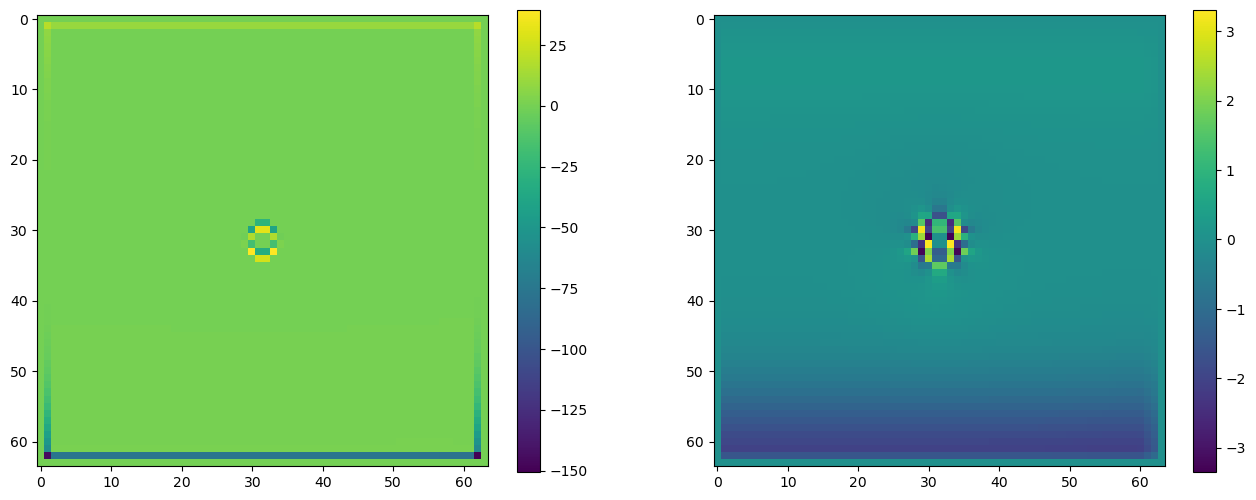

In [31]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(laplassian_p))

g_im = ax_g.imshow(np.rot90(g))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

Whoops! We have a probelem: LHS and RHS of Poisson's Equation are not equal. Maybe There is a problem with simulator, since it calculates Pressure in a strange way. Let's try another one with strict realization 

# Simulator 2 
in `fluid_sim2.py` we re-implement simulator from this [video](https://www.youtube.com/watch?v=63Ik8uZMxCQ)
It has two steps: calculating pressure and adjucting velocities

In [1]:
from fluid_sim2 import Fluid as Fluid2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fl2 = Fluid2()

In [3]:
# we take on full iteration and one for only solving P
fl2.solve(0.001)
fl2.advect(0.001)
fl2.solve(0.001)

In [4]:
# as with previous simulator let's check Poison's Equastion
laplassian_p = np.zeros((64, 64))
dx = dy = fl2.h
for i in range(1, fl2.nx - 1):
    for j in range(1, fl2.ny - 1):
        laplassian_p[i, j] = (fl2.p[i+1,j] - 2*fl2.p[i,j] + fl2.p[i-1,j]) / dx**2 + (fl2.p[i, j+1] - 2*fl2.p[i,j] + fl2.p[i,j-1]) / dy**2

In [5]:
g = np.zeros((64,64))
for i in range(1, fl2.nx - 1):
    for j in range(1, fl2.ny - 1):
        g[i,j] = fl2.rho / 0.001 * ((fl2.u[i+1, j] - fl2.u[i-1,j]) / (2*dx) + (fl2.v[i,j+1] - fl2.v[i,j-1]) / (2*dy))

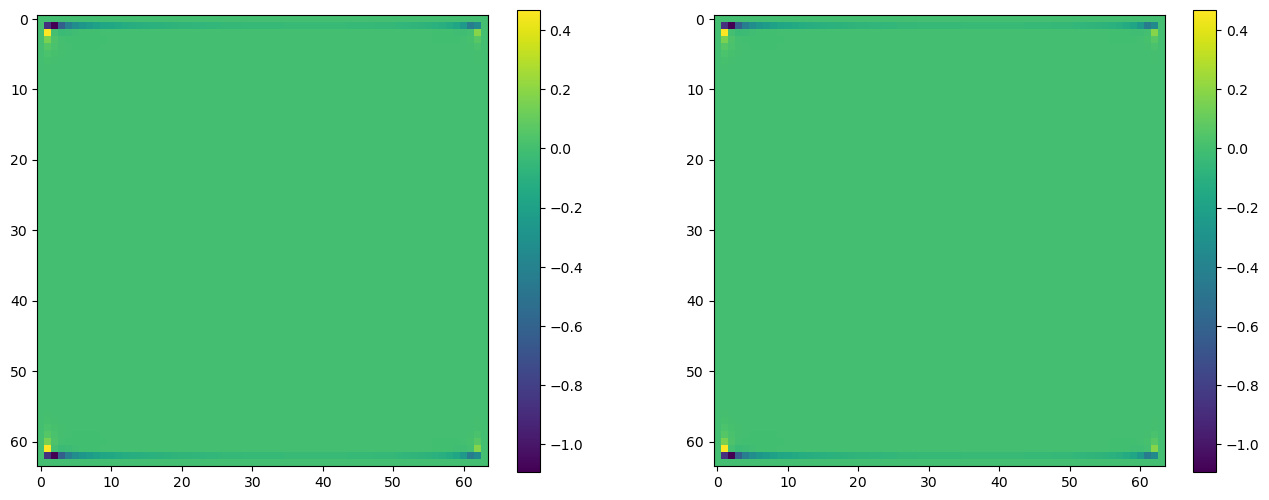

In [6]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(laplassian_p))

g_im = ax_g.imshow(np.rot90(g))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

It seems they are simmilar and we can use it to train our networks! Let's also show pressure and horizontal velocity

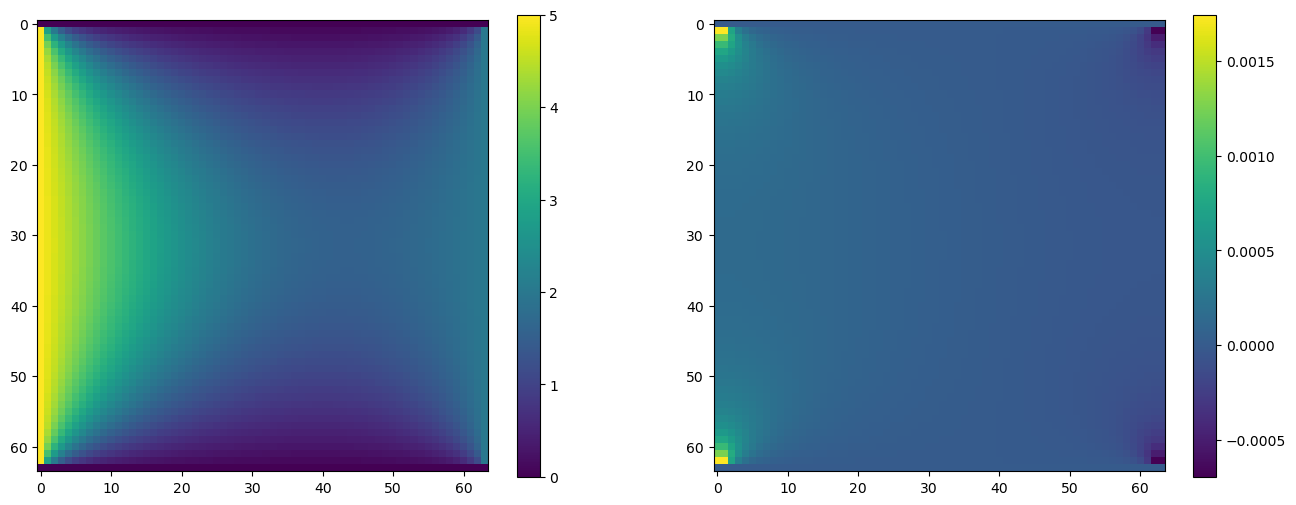

In [7]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(fl2.p))

g_im = ax_g.imshow(np.rot90(fl2.u))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

Looking Ok, but it's better to check it's work in animation after we obtain some data later (this simulator is quite slow)

# Checking dataset generation
Now, let's look the short sample generated by this simulator called like

`python .\fluid_sim2.py --dst short.npz --frames 10`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# %matplotlib inline

In [2]:
sample = np.load('short.npz')

In [3]:
for key in sample.keys():
    print(key, sample[key].shape)

p (11, 64, 64)
v (11, 64, 64)
u (11, 64, 64)


In [4]:
# let's plot animation
fig, (ax_p, ax_v, ax_u) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax_p.axis('off')
ax_v.axis('off')
ax_u.axis('off')

class Scene:
    def __init__(self):
        self.frame = []
    
    def animate(self, i):
        while self.frame:
            self.frame[-1].remove()
            self.frame.pop()
            
        self.frame.append(ax_p.imshow(np.rot90(sample['p'][i])))
        self.frame.append(ax_u.imshow(np.rot90(sample['u'][i])))
        self.frame.append(ax_v.imshow(np.rot90(sample['v'][i])))
        return self.frame

scene=Scene()
ani = animation.FuncAnimation(fig, scene.animate, frames=sample['p'].shape[0], interval=int(1000 / 5), blit=True,                                 
                                  repeat=False)
plt.close()
HTML(ani.to_jshtml())
# plt.show()

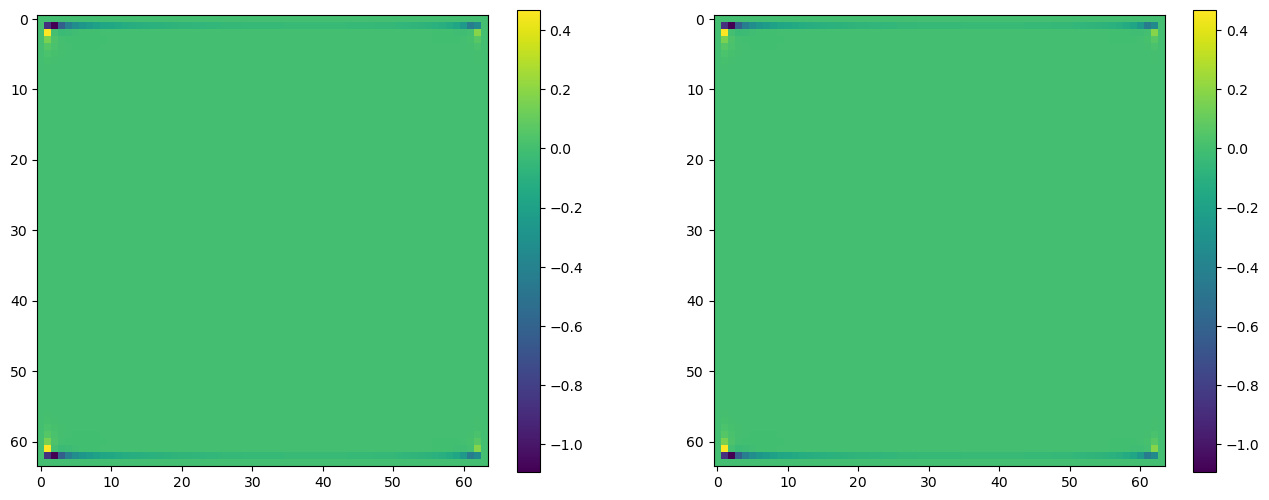

In [10]:
# as with previous simulator let's check Poison's Equastion with the same frame as before (2nd for p and 1st for u and v)
dx = dy = 1.
nx = ny = sample['p'].shape[1]
frame = 2
rho = 1.

laplassian_p = np.zeros((64, 64))

for i in range(1, nx-1):
    for j in range(1, ny-1):
        laplassian_p[i, j] = ((sample['p'][frame,i+1,j] - 2*sample['p'][frame,i,j] + sample['p'][frame,i-1,j]) / dx**2 
                              + (sample['p'][frame,i, j+1] - 2*sample['p'][frame,i,j] + sample['p'][frame,i,j-1]) / dy**2)
        
g = np.zeros((64,64))
for i in range(1, nx - 1):
    for j in range(1, ny - 1):
        g[i,j] = rho / 0.001 * ((sample['u'][frame-1, i+1, j] - sample['u'][frame-1,i-1,j]) / (2*dx) 
                                + (sample['v'][frame-1, i,j+1] -  sample['v'][frame-1,i,j-1]) / (2*dy))
        
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(laplassian_p))

g_im = ax_g.imshow(np.rot90(g))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

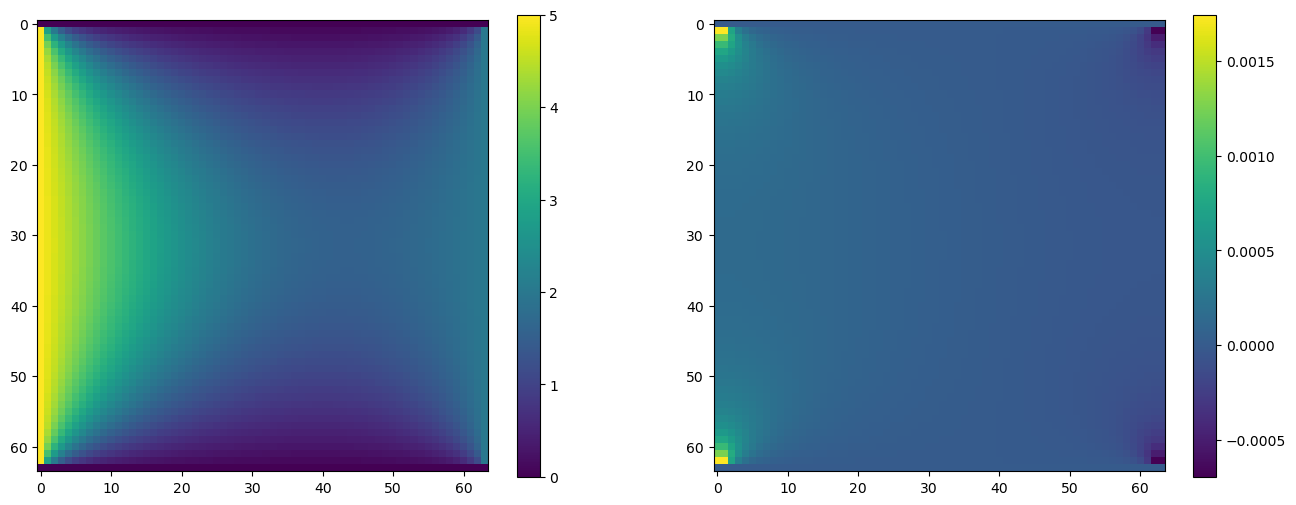

In [11]:
# Show our obtained figures
fig, (ax_p, ax_g) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
p_im = ax_p.imshow(np.rot90(sample['p'][frame]))

g_im = ax_g.imshow(np.rot90(sample['u'][frame-1]))
fig.colorbar(p_im)
fig.colorbar(g_im)
plt.show()

Finally, our dateset generation script is working as it has to. So' we can generate more data and start building the neural netwrorks!